# Tutorial 2: Comparison to other methods of uncertainty quantification

In this tutorial we will investigate what are some benefits of Bayesian Neural Networks (BNN) over point estimate Neural Networks. We will also look at other uncertainty quantification methods, including conformal prediction.

Import standard libraries and setting random seeds for reproducibility.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

torch.manual_seed(42)
np.random.seed(42)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Simulate Data


Let’s simulate a wiggly line and draw observations in separated regions…

In [2]:
def get_simple_data_train():
    x = np.linspace(-.2, 0.2, 500)
    x = np.hstack([x, np.linspace(.6, 1, 500)])
    eps = 0.02 * np.random.randn(x.shape[0])
    y = x + 0.3 * np.sin(2 * np.pi * (x + eps)) + 0.3 * np.sin(4 * np.pi * (x + eps)) + eps
    x_train = torch.from_numpy(x).float()[:, None]
    y_train = torch.from_numpy(y).float()
    return x_train, y_train

In [3]:
def plot_generic(add_to_plot=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xlim([-.5, 1.5])
    plt.ylim([-1.5, 2.5])
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    x_train, y_train = get_simple_data_train()

    x_true = np.linspace(-.5, 1.5, 1000)
    y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

    ax.plot(x_train, y_train, 'ko', markersize=4, label="observations")
    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    if add_to_plot is not None:
        add_to_plot(ax)

    plt.legend(loc=4, fontsize=15, frameon=False)
    plt.show()

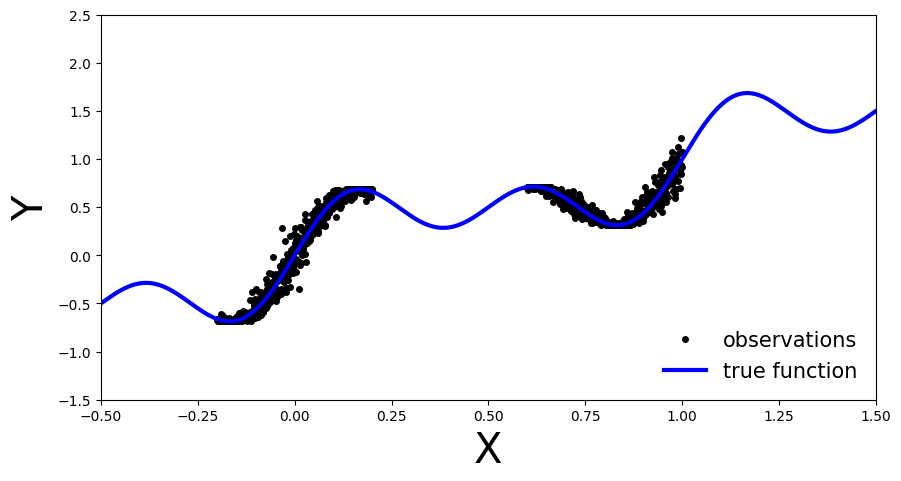

In [4]:
plot_generic()

As you can see, we have the true function in blue. The observations are observable in two regions of the function and there is some noise in their measurement. We will use this simple data to showcase the differences between BNNs and deterministic NNs.

## Define non-Bayesian Neural Network

First let’s create our point estimate neural network, in other words a standard fully connected MLP. We will define the number of hidden layers dynamically so we can reuse the same class for different depths. We will also add a dropout flag, this will allow us to easily use the same architecture for our BNN.

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=10, n_hidden_layers=1, use_dropout=False):
        super().__init__()

        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.activation = nn.Tanh()

        # dynamically define architecture
        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = nn.ModuleList(layer_list)

    def forward(self, input):
        hidden = self.activation(self.layers[0](input))
        for layer in self.layers[1:-1]:
            hidden_temp = self.activation(layer(hidden))

            if self.use_dropout:
                hidden_temp = self.dropout(hidden_temp)

            hidden = hidden_temp + hidden  # residual connection

        output_mean = self.layers[-1](hidden).squeeze()
        return output_mean

## Train one deterministic NN

### Training

Now let’s train our MLP with the training data we generated above:



In [6]:
def train(net, train_data):
    x_train, y_train = train_data
    optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    progress_bar = trange(3000)
    for _ in progress_bar:
        optimizer.zero_grad()
        loss = criterion(y_train, net(x_train))
        progress_bar.set_postfix(loss=f'{loss / x_train.shape[0]:.3f}')
        loss.backward()
        optimizer.step()
    return net

In [7]:
train_data = get_simple_data_train()
x_test = torch.linspace(-.5, 1.5, 3000)[:, None]  # test over the whole range

net = MLP(hidden_dim=30, n_hidden_layers=2)
net = train(net, train_data)
y_preds = net(x_test).clone().detach().numpy()

100%|██████████| 3000/3000 [00:02<00:00, 1027.86it/s, loss=0.000]


### Evaluate

Let’s investigate how our deterministic MLP generalizes over the entire domain of our input variable 
 (the model was only trained on the observations, now we will also pass in data outside this region)



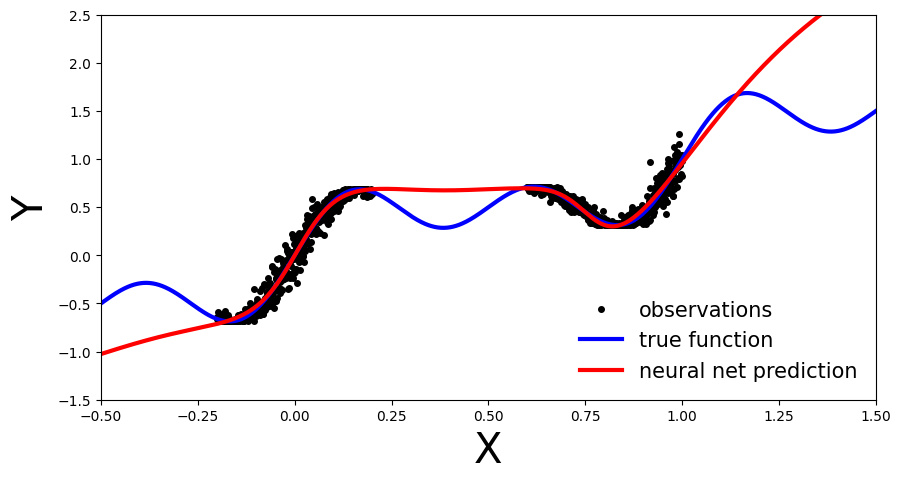

In [8]:
def plot_predictions(x_test, y_preds):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'r-', linewidth=3, label='neural net prediction')

    plot_generic(add_predictions)
plot_predictions(x_test, y_preds)

We can see that our deterministic MLP (red line) has correctly learned the data distribution in the training regions, however, as the model has not learned the underlying sinusoidal wave function, it’s predictions outside the training region are inaccurate. As our MLP is a point estimate NN we have no measure confidence in the predictions outside the training region. In the upcoming sections let’s see how this compares to BNN.

## Deep Ensemble


Deep ensembles were first introduced by [Lakshminarayanan et al. (2017)](https://arxiv.org/abs/1612.01474). As the name implies multiple point estimate NN are trained, *an ensemble*, and the final prediction is computed as an average across the models. From a Bayesian perspective the different point estimates correspond to modes of a Bayesian posterior. This can be interpreted as approximating the posterior with a distribution parametrized as multiple Dirac deltas:

$$
q_{\phi}(\theta | D) = \sum_{\theta_{i} ∈ ϕ} \alpha_{\theta_{i}} δ_{\theta_{i}}(\theta)
$$
where $\alpha_{\theta_{i}}$ are positive constants such that their sum is equal to one.

**Training**

We will reuse the MLP architecture introduced before, simply now we will train an ensemble of such models

In [9]:
ensemble_size = 5
ensemble = [MLP(hidden_dim=10, n_hidden_layers=5) for _ in range(ensemble_size)]
for net in ensemble:
    train(net, train_data)

100%|██████████| 3000/3000 [00:04<00:00, 653.16it/s, loss=0.000]


**Evaluate**

Same as before, let's investigate how our Deep Ensemble performs on the entire data domain of our input variable $x$.

In [10]:
y_preds = [np.array(net(x_test).clone().detach().numpy()) for net in ensemble]

Plot each ensemble member's predictive function.

In [11]:
def plot_multiple_predictions(x_test, y_preds):
    def add_multiple_predictions(ax):
        for idx in range(len(y_preds)):
            ax.plot(x_test, y_preds[idx], '-', linewidth=3)

    plot_generic(add_multiple_predictions)

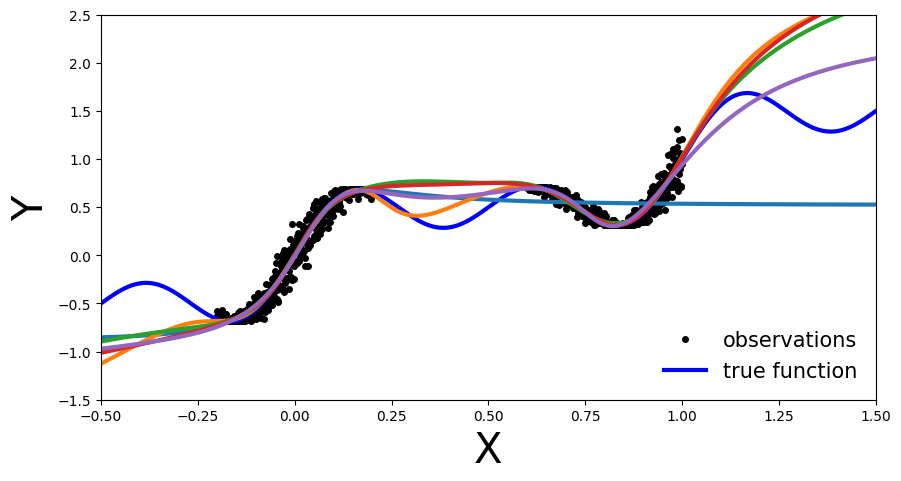

In [12]:
plot_multiple_predictions(x_test, y_preds)

In this plot the benefit of an ensemble approach is not immediately clear. Still on the regions outside the training data each of the trained NN is inaccurate. So what is the benefit you might ask.

Well let's plot the above in a slightly different way: let's visualize the ensemble's **uncertainty bands**.
> From a Bayesian perspective we want to quantify the model's uncertainty on its prediction. This is done via the marginal $p(y|x, D)$, which can be computed as:

$$
p(y|x, D) = \int_{\theta}p(y|x,\theta')p(\theta'|D)d\theta'
$$

> In practice, for Deep Ensembles we approximate the above by computing the mean and standard deviation across the ensemble. Meaning $p(\theta|D)$ represents the parameters of one of the trained models, $\theta_{i} ∼ p(\theta|D)$, which we then use to compute $y_{i} = f(x,\theta_{i})$, representing $p(y|x,\theta')$.


In [13]:
def plot_uncertainty_bands(x_test, y_preds):
    y_preds = np.array(y_preds)
    y_mean = y_preds.mean(axis=0)
    y_std = y_preds.std(axis=0)

    def add_uncertainty(ax):
        ax.plot(x_test, y_mean, '-', linewidth=3, color="#408765", label="predictive mean")
        ax.fill_between(x_test.ravel(), y_mean - 2 * y_std, y_mean + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plot_generic(add_uncertainty)

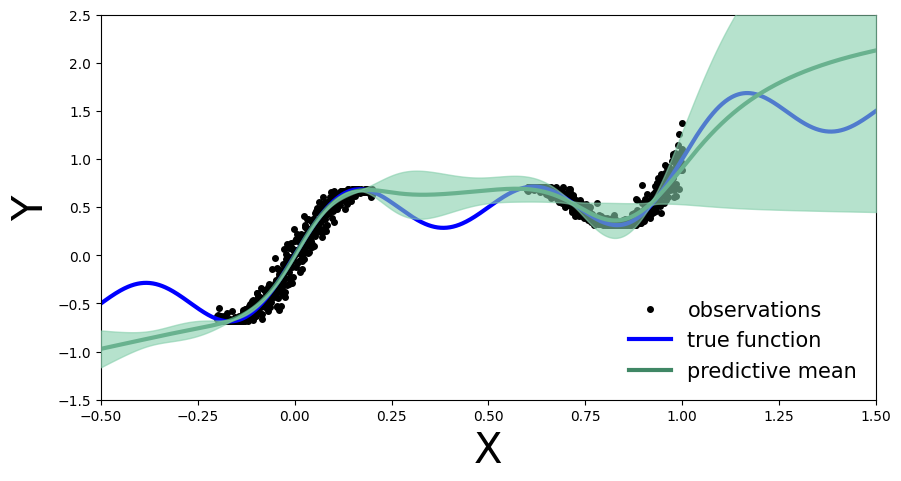

In [14]:
plot_uncertainty_bands(x_test, y_preds)

Now we see the benefit of a Bayesian approach. Outside the training region we not only have the point estimate, but also model's uncertainty about its prediction.

## Monte Carlo Dropout

First we create our MC-Dropout Network. As you can see in the code below, creating a dropout network is extremely simple:
We can reuse our existing network architecture, the only alteration is that during the forward pass we randomly *switch off* (zero) some of the elements of the input tensor.

The Bayesian interpretation of MC-Dropout is that we can see each dropout configuration as a different sample from the approximate posterior distribution $\theta_{i} ∼ q(\theta|D)$.


**Training**

In [16]:
net_dropout = MLP(hidden_dim=10, n_hidden_layers=5, use_dropout=True)
net_dropout = train(net_dropout, train_data)

100%|██████████| 3000/3000 [00:05<00:00, 552.04it/s, loss=0.000]


**Evaluate**

Similarly to Deep Ensembles, we pass the test data multiple times through the MC-Dropout network. We do so to obtain $y_{i}$ at the different parameter settings, $\theta_{i}$ of the network, $y_{i}=f(x,\theta_{i})$, governed by the dropout mask.

>This is the main difference compared to dropout implementation in a deterministic NN where it serves as a regularization term. In normal dropout application during test time the dropout is **not** applied. Meaning that all connections are present, but the weights are [adjusted](https://cs231n.github.io/neural-networks-2/)

In [17]:
n_dropout_samples = 100

# compute predictions, resampling dropout mask for each forward pass
y_preds = [net_dropout(x_test).clone().detach().numpy() for _ in range(n_dropout_samples)]
y_preds = np.array(y_preds)

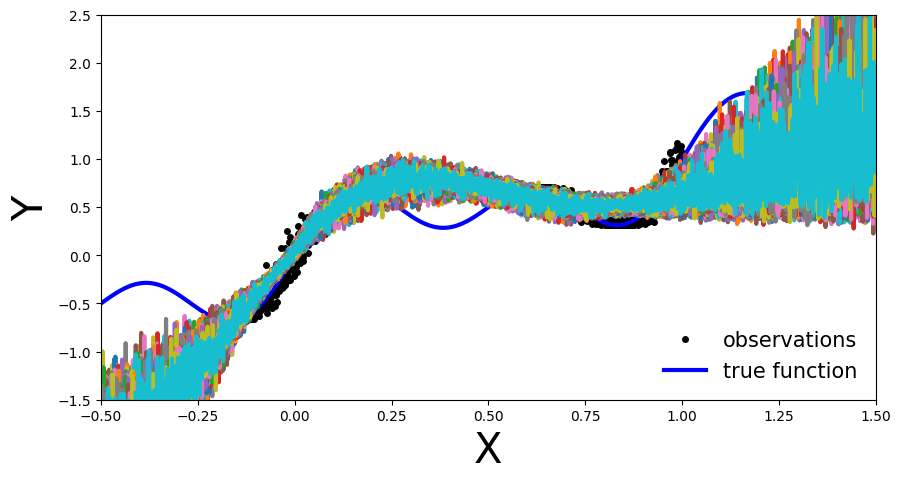

In [18]:
plot_multiple_predictions(x_test, y_preds)

In the above plot each colored line (apart from blue) represents a different parametrization, $\theta_{i}$, of our MC-Dropout Network.

Likewise to the Deep Ensemble Network, we can also compute the MC-dropout's **uncertainty bands**.

> The approach in practice is the same as before: we compute the mean and standard deviation across each dropout mask, which corresponds to the marginal estimation we discussed earlier.

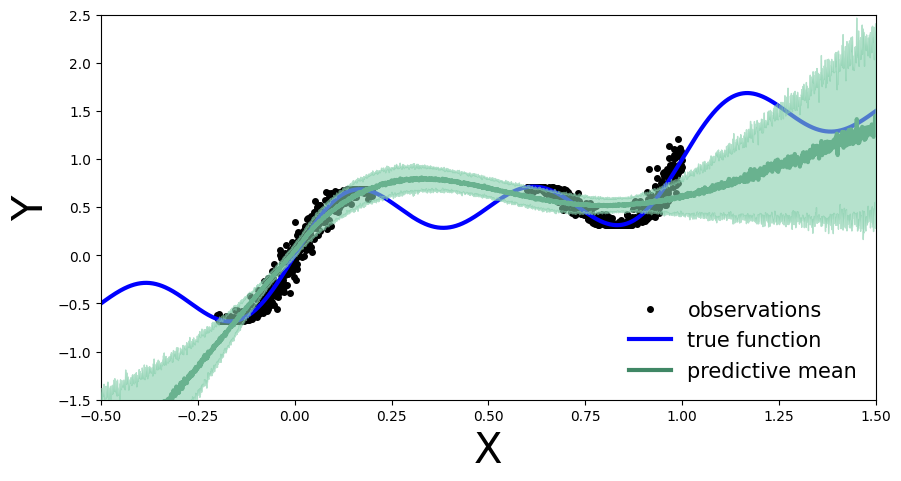

In [19]:
plot_uncertainty_bands(x_test, y_preds)

In the same way as Deep Ensembles, MC-Dropout allows us to have an uncertainty estimate next to our point wise predictions. However, for the given use-case this has come with the cost of an overall drop in the model's performance on the training regions. We observe this because at every pass through our network we randomly choose which nodes to keep, so one could argue that we hinder the networks optimal performance.